## Seq2Seq Model

基于序列到序列的翻译模型实现一个问答模型，即：问题到答案的翻译。

### 数据集

cMedQA2：中文医学问答的数据集的2.0版本，数据是匿名的，不包括任何个人信息。

| DataSet | #Ques | #Ans | Ave. #words per Question |  Ave. #words per Answer| Ave. #characters per Question | Ave. #characters per Answer |
| :-: | :-: | :-: | :-: | :-: | :-: | :-: |
|Train|100,000|188,490|-|-|48|101|
|Dev|4,000|7,527|-|-|49|101|
|Test|4,000|7,552|-|-|49|100|
|Total|108,000|203,569|-|-|49|101|

* **questions.csv** ：全部的问题数据
* **answers.csv** ：全部的答案数据   
* **train_candidates.txt** 、 **test_candidates.txt** ：划分好的训练测试集

In [1]:
import os
import jieba
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
 
os.environ['TF_CPP_MIN_LOG_LEVEL']='2' 

In [2]:
question_df = pd.read_csv('/home/wjh/DataSet/cMedQA2-master/question.csv')

answer_df = pd.read_csv('/home/wjh/DataSet/cMedQA2-master/answer.csv')

In [3]:
question_df.head()

,question_id,content
0,65102009,头痛恶心肌肉痛关节痛颈部淋巴结疼痛怎么回事啊
1,44275784,我怀孕37周，肠子一直呼噜呼噜叫感觉像是在里面灌水，上厕所拉稀和喷水一样，一天上厕所5次，对...
2,42163349,男，67岁，2天前突然出现右小腿（类似抽筋症状），现出现右小腿消肿，有指压痕，无，请问可能是...
3,67935540,怀孕前两个月照了CT和X光，来两次月经后怀孕了，怀孕期间有轻微盆腔积水吃了两瓶杏香兔耳片。请...
4,33429289,阴囊湿冷阳痿早泻请问用点什么药


In [4]:
answer_df.head()

,ans_id,question_id,content
0,0,45619783,月经延迟十四天而且伴随恶心，头痛，乏力的现象，那么考虑怀孕的概率是非常大的，建议你去医院检查...
1,1,45619783,如果你的月经周期规律，有正常的性生活，未采取任何有效的避孕措施，此时的症状考虑有怀孕的可能。...
2,2,45619783,建议在性生活过后14天左右可以用怀孕试纸自我检测一下，一般怀孕试纸显示2条线的话是怀孕了的，...
3,3,26616465,头痛是临床上最为常见的临床症状之一，是人体对各种致痛因素所产生的主观感觉，属于疼痛的范畴。建...
4,4,26616465,头痛主要是由于头部的血管、神经、脑膜等对疼痛敏感的组织受到刺激引起的。由紧张、疲劳、饮酒等原...


#### 数据预处理
1. 对文本进行分词
2. 添加开始和结束的token:`[START],[END]`
3. 创建词到索引的的映射关系`word->id->word`
    - 如果是不同语言之间的翻译要创建两套不同的映射关系
    - 同一种语言的问答模型一组映射关系即可，但也可以使用两组
4. 填充文本到固定的最大长度

In [5]:
question_df['wordslist'] = question_df.content.apply(lambda x: list(jieba.cut(x)))

question_df['wordlist'] = question_df.content.apply(lambda x: list(x))

Building prefix dict from the default dictionary ...
Loading model from cache /tmp/jieba.cache
Loading model cost 0.810 seconds.
Prefix dict has been built successfully.


In [6]:
answer_df['wordslist'] = answer_df.content.apply(lambda x: list(jieba.cut(x)))

answer_df['wordlist'] = answer_df.content.apply(lambda x: list(x))

In [7]:
question_df.head(3)

,question_id,content,wordslist,wordlist
0,65102009,头痛恶心肌肉痛关节痛颈部淋巴结疼痛怎么回事啊,"[头痛, 恶心, 肌肉, 痛, 关节痛, 颈部, 淋巴结, 疼痛, 怎么回事, 啊]","[头, 痛, 恶, 心, 肌, 肉, 痛, 关, 节, 痛, 颈, 部, 淋, 巴, 结, ..."
1,44275784,我怀孕37周，肠子一直呼噜呼噜叫感觉像是在里面灌水，上厕所拉稀和喷水一样，一天上厕所5次，对...,"[我, 怀孕, 37, 周, ，, 肠子, 一直, 呼噜, 呼噜, 叫, 感觉, 像是, 在...","[我, 怀, 孕, 3, 7, 周, ，, 肠, 子, 一, 直, 呼, 噜, 呼, 噜, ..."
2,42163349,男，67岁，2天前突然出现右小腿（类似抽筋症状），现出现右小腿消肿，有指压痕，无，请问可能是...,"[男, ，, 67, 岁, ，, 2, 天前, 突然, 出现, 右小腿, （, 类似, 抽筋...","[男, ，, 6, 7, 岁, ，, 2, 天, 前, 突, 然, 出, 现, 右, 小, ..."


In [8]:
answer_df.head(3)

,ans_id,question_id,content,wordslist,wordlist
0,0,45619783,月经延迟十四天而且伴随恶心，头痛，乏力的现象，那么考虑怀孕的概率是非常大的，建议你去医院检查...,"[月经, 延迟, 十四天, 而且, 伴随, 恶心, ，, 头痛, ，, 乏力, 的, 现象,...","[月, 经, 延, 迟, 十, 四, 天, 而, 且, 伴, 随, 恶, 心, ，, 头, ..."
1,1,45619783,如果你的月经周期规律，有正常的性生活，未采取任何有效的避孕措施，此时的症状考虑有怀孕的可能。...,"[如果, 你, 的, 月经周期, 规律, ，, 有, 正常, 的, 性生活, ，, 未, 采...","[如, 果, 你, 的, 月, 经, 周, 期, 规, 律, ，, 有, 正, 常, 的, ..."
2,2,45619783,建议在性生活过后14天左右可以用怀孕试纸自我检测一下，一般怀孕试纸显示2条线的话是怀孕了的，...,"[建议, 在, 性生活, 过后, 14, 天, 左右, 可以, 用, 怀孕, 试纸, 自我,...","[建, 议, 在, 性, 生, 活, 过, 后, 1, 4, 天, 左, 右, 可, 以, ..."


问题词频统计：

In [25]:
qwords_counts = {}
for q in question_df.wordslist:
    for words in q:
        if words in qwords_counts:
            qwords_counts[words] += 1
        else:
            qwords_counts[words] = 0

In [31]:
awords_counts = {}
for a in answer_df.wordslist:
    for words in a:
        if words in awords_counts:
            awords_counts[words] += 1
        else:
            awords_counts[words] = 0

In [33]:
qwords_set = set([words for words in qwords_counts.keys()])
awords_set = set([words for words in awords_counts.keys()])

- len(qwords_counts), len(awords_counts): (60436, 82837)

- len(qwords_set.intersection(awords_set)) : 32068

划分训练和测试数据：

In [9]:
train_ids = pd.read_csv('/home/wjh/DataSet/cMedQA2-master/train_candidates.txt')

test_ids = pd.read_csv('/home/wjh/DataSet/cMedQA2-master/test_candidates.txt')

test_ids = test_ids.drop_duplicates('question_id')

train_ids = train_ids.drop_duplicates('question_id')

In [10]:
train_data = train_ids.merge(question_df[['question_id','wordslist']], on='question_id', how='left')

train_data = train_data.merge(answer_df[['ans_id','wordslist']], left_on='pos_ans_id', right_on='ans_id')

test_data = test_ids.merge(question_df[['question_id','wordslist']], on='question_id', how='left')

test_data = test_data.merge(answer_df[['ans_id','wordslist']], on='ans_id', how='left')

In [92]:
test_data.head(3)

,question_id,ans_id,cnt,label,wordslist_x,wordslist_y
0,23423734,137315,0,1,"[我, 的, 右脚, 外, 踝骨, 折, 一年, 多, ・, 平时, 有脚, 走路, 不敢,...","[你, 的, 情况, 考虑, 局部, 有, 炎症, 的, 可能性, 大, 一些, 。, 建议..."
1,6469692,153600,0,1,"[全部, 症状, ：, 手指, 关节, 不, 小心, 韧带, 扭伤, 现在, 关节, 肿大,...","[首先, 建议, 拍片, 看看, 是否是, 有, 骨折, 啊, 。, 如果, 没有, 骨折,..."
2,4833968,51452,0,1,"[请问, 一下, 脑袋, 疼, 的, 厉害, ，, 基本, 整个, 脑袋, 都, 疼, ，,...","[如果, 你, 有, 这方面, 的, 烦恼, ，, 请, 先到, 正规, 的, 医院, 诊断..."


In [11]:
train_qs = np.array([' '.join(wordslist) for wordslist in train_data.wordslist_x])

train_as = np.array([' '.join(wordslist) for wordslist in train_data.wordslist_y])

test_qs = np.array([' '.join(wordslist) for wordslist in test_data.wordslist_x])

test_as = np.array([' '.join(wordslist) for wordslist in test_data.wordslist_y])

In [91]:
test_as[:3]

array(['你 的 情况 考虑 局部 有 炎症 的 可能性 大 一些 。 建议 服用 红 药片 ， 乙酰螺旋霉素 片 等 治疗 观察 。 必要 时 拍 X 线 明确 诊断 。',
       '首先 建议 拍片 看看 是否是 有 骨折 啊 。 如果 没有 骨折 可能 是 软组织 伤 啊 。 建议 前 3 天 冷敷 。 3 天后 热敷 试试 。',
       '如果 你 有 这方面 的 烦恼 ， 请 先到 正规 的 医院 诊断 ， 再 根据 医生 的 指导 进行 治疗 ， 切勿 自行 用药 。'],
      dtype='<U402')

In [88]:
question_seq_lengths = [len(qes) for qes in train_data.wordslist_x]
answer_seq_lengths = [len(qes) for qes in train_data.wordslist_y]

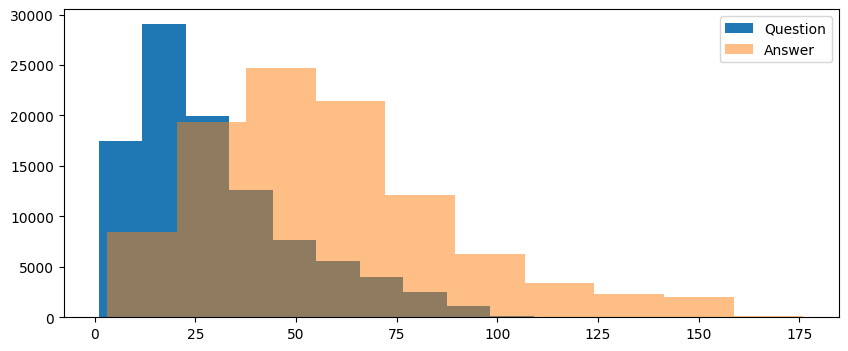

In [97]:
plt.figure(figsize=(10, 4))
_ = plt.hist(question_seq_lengths, label='Question')
_ = plt.hist(answer_seq_lengths, alpha=0.5, label='Answer')
plt.legend()

创建tf.DataSet：

In [12]:
BUFFER_SIZE = len(train_qs)
BATCH_SIZE = 64

train_ds = (tf.data.Dataset
              .from_tensor_slices((train_qs, train_as))
              .shuffle(BUFFER_SIZE)
              .batch(BATCH_SIZE))
test_ds = (tf.data.Dataset
             .from_tensor_slices((test_qs, test_as))
             .shuffle(BUFFER_SIZE)
             .batch(BATCH_SIZE))

In [13]:
for example_question_strings, example_answer_strings in train_ds.take(1):
    print(example_question_strings[:1].numpy()[0].decode("UTF-8","strict"))
    print()
    print(example_answer_strings[:1].numpy()[0].decode("UTF-8","strict"))
    break

腹中 有 痞块 要 做 哪些 检查

女性 腹部 包块 主要 考虑 生殖系统 的 问题 （ 如 附件炎 、 卵巢囊肿 等 ） ， 首选 留尿后 B超 检查 ， 另外 还 应该 超声 检查 肝胆 、 双肾 等 。 总之 首选 B超 检查 ， 根据 医师 的 再进一步 做 其他 相关 的 辅助 检查 。 建议 及时 到 医院 就医 ， B超 后 遵 医嘱 做 相关 进一步 检查 。


#### 创建文本向量化层

- 构建词到索引的映射关系
- 添加开始和结束符

In [14]:
def add_start_end_token(text):
    # Strip whitespace.
    text = tf.strings.strip(text)
    text = tf.strings.join(['[START]', text, '[END]'], separator=' ')
    return text

In [15]:
example_text = example_answer_strings[0]

print(example_text.numpy().decode())
print(add_start_end_token(example_text).numpy().decode())

女性 腹部 包块 主要 考虑 生殖系统 的 问题 （ 如 附件炎 、 卵巢囊肿 等 ） ， 首选 留尿后 B超 检查 ， 另外 还 应该 超声 检查 肝胆 、 双肾 等 。 总之 首选 B超 检查 ， 根据 医师 的 再进一步 做 其他 相关 的 辅助 检查 。 建议 及时 到 医院 就医 ， B超 后 遵 医嘱 做 相关 进一步 检查 。
[START] 女性 腹部 包块 主要 考虑 生殖系统 的 问题 （ 如 附件炎 、 卵巢囊肿 等 ） ， 首选 留尿后 B超 检查 ， 另外 还 应该 超声 检查 肝胆 、 双肾 等 。 总之 首选 B超 检查 ， 根据 医师 的 再进一步 做 其他 相关 的 辅助 检查 。 建议 及时 到 医院 就医 ， B超 后 遵 医嘱 做 相关 进一步 检查 。 [END]


问题文本向量化：

In [16]:
question_vocab_size = 60436 
question_max_length = 75

question_vectorization_layer = tf.keras.layers.TextVectorization(
                                standardize = add_start_end_token,
                                max_tokens = question_vocab_size,
                                output_mode = 'int',
                                output_sequence_length = question_max_length)

In [17]:
question_vectorization_layer.adapt(train_ds.map(lambda question, answer: question))

# the first 10 words from the question vocabulary:
question_vectorization_layer.get_vocabulary()[:10]

['', '[UNK]', '，', '[START]', '[END]', '了', '的', '。', '？', '我']

答案文本向量化:

In [18]:
answer_vocab_size = 82837 
answer_max_length = 125

answer_vectorization_layer = tf.keras.layers.TextVectorization(
                                standardize = add_start_end_token,
                                max_tokens = answer_vocab_size,
                                output_mode = 'int',
                                output_sequence_length = answer_max_length)

In [19]:
answer_vectorization_layer.adapt(train_ds.map(lambda question, answer: answer))

# the first 10 words from the question vocabulary:
answer_vectorization_layer.get_vocabulary()[:10]

['', '[UNK]', '，', '的', '。', '是', '[START]', '[END]', '、', '治疗']

文本的向量化层可以把文本从字符串，转化为对应的索引序列：
- text $\to$ tokens，填充字符的索引为：0，很容易转换为掩码。

In [20]:
example_tokens = question_vectorization_layer(example_question_strings)
example_tokens[:1, :]

<tf.Tensor: shape=(1, 75), dtype=int64, numpy=
array([[    3,  6675,    11, 36101,    55,    24,   290,    18,     4,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0]])>

tokens $\to$ text

In [21]:
question_vocab = np.array(question_vectorization_layer.get_vocabulary())
tokens = question_vocab[example_tokens[0].numpy()]
' '.join(tokens)

'[START] 腹中 有 痞块 要 做 哪些 检查 [END]                                                                  '

可视化Token

Text(0.5, 1.0, 'Mask')

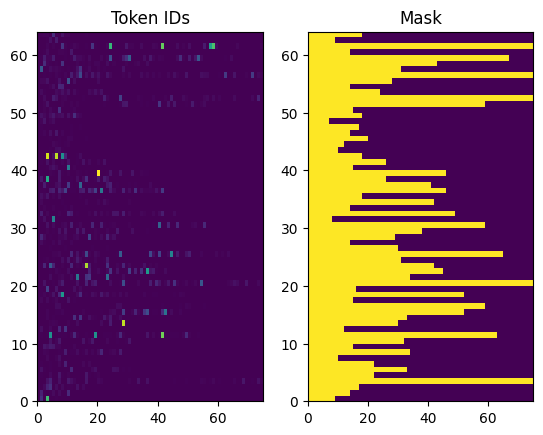

In [22]:
plt.subplot(1, 2, 1)
plt.pcolormesh(example_tokens.numpy())
plt.title('Token IDs')

plt.subplot(1, 2, 2)
plt.pcolormesh(example_tokens.numpy() != 0)
plt.title('Mask')

#### 创建训练数据集

创建喂给模型的数据格式，当前的数据格式为（question,answer)对，要转为((question, answer_in),answer_out)对。(question, answer_in)作为模型的输入，answer_out为模型的输出，也就是标签。answer_in 和 answer_out 之间的区别在于它们相对于彼此移动一个位置的索引，因此answer_out在每个位置的token索引都是answer_in的下一个token的索引。

例如:
- answer_in : 1, 2, 3, 4, 5
- answer_out: 2, 3, 4, 5, 6

In [23]:
def process_ds(question, answer):
    question = question_vectorization_layer(question)
    answer = answer_vectorization_layer(answer)
    answer_in = answer[:,:-1]
    answer_out = answer[:,1:]
    return (question, answer_in), answer_out

In [24]:
train_ds = train_ds.map(process_ds, tf.data.AUTOTUNE)
test_ds = test_ds.map(process_ds, tf.data.AUTOTUNE)

In [25]:
for (question_tok, answer_in), answer_out in train_ds.take(1):
    print("Question :", question_tok[0, :10].numpy()) 
    print()
    print("Answer_in:",answer_in[0, :10].numpy()) 
    print("Answer_out:",answer_out[0, :10].numpy())

Question : [    3   136   195 40116   391  6069    10   445    42     8]

Answer_in: [    6   247    10   274     3    15   114   945   916 20158]
Answer_out: [  247    10   274     3    15   114   945   916 20158  1406]


### 编码器

 BRNN : bidirectional RNN
- 通过文本向量化层，获取token（词）的索引序列。
- 通过嵌入层查找每个token的嵌入向量。
- 将转换后的词向量序列输入到BRNN中。
- 返回处理后的序列，传递给注意力层。

编码器的目标是将上下文序列处理为对解码器有用的向量序列，由于上下文序列是恒定的，因此对信息在编码器中的流动方式没有限制，因此使用双向RNN进行处理：

In [351]:
tf.repeat(tf.expand_dims(tf.range(75),axis=0),repeats=64,axis=0).shape[0]

64

In [26]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self, text_processor, units=256):
        super(Encoder, self).__init__()
        self.text_processor = text_processor
        self.vocab_size = text_processor.vocabulary_size()
        self.units = units

        # The embedding layer converts tokens to vectors
        self.embedding = tf.keras.layers.Embedding(self.vocab_size, units,
                                                   mask_zero=True)

        # The RNN layer processes those vectors sequentially.
        self.rnn = tf.keras.layers.Bidirectional(merge_mode='sum',
                                   layer=tf.keras.layers.GRU(units,
                                   # Return the sequence and state
                                   return_sequences=True,
                                   recurrent_initializer='glorot_uniform'))

    def call(self, x):
        # looks up the embedding vector for each token.
        x = self.embedding(x)
        
        # GRU processes the sequence of embeddings.
        x = self.rnn(x)

        # Returns the new sequence of embeddings.
        return x

    def convert_input(self, texts):
        texts = tf.convert_to_tensor(texts)
        if len(texts.shape) == 0:
            texts = tf.convert_to_tensor(texts)[tf.newaxis]
        tokens = self.text_processor(texts)
        x = self(tokens)
        return x

In [27]:
# Encode the input sequence.
encoder = Encoder(question_vectorization_layer)
ex_question = encoder(question_tok)

print(f'question tokens, shape (batch, s): {question_tok.shape}')
print(f'Encoder output, shape (batch, s, units): {ex_question.shape}')

question tokens, shape (batch, s): (64, 75)
Encoder output, shape (batch, s, units): (64, 75, 256)


#### 注意力层

注意层允许解码器访问编码器提取的信息。它从整个上下文序列中计算得到一个向量，并将其添加到解码器的输出中。
把整个序列中压缩为单个向量的最简单方法是取整个序列（层）的平均值。GlobalAveragePooling1D）。注意力层类似，但计算上下文序列中的加权平均值。其中权重是根据上下文和“查询”向量的组合计算的。

In [49]:
class CrossAttention(tf.keras.layers.Layer):
    def __init__(self, units=256, **kwargs):
        super().__init__()
        self.mha = tf.keras.layers.MultiHeadAttention(key_dim=units, num_heads=2, **kwargs)
        self.layernorm = tf.keras.layers.LayerNormalization()
        self.add = tf.keras.layers.Add()

    def call(self, x, context):
        attn_output, attn_scores = self.mha(query=x,value=context,
                                            return_attention_scores=True)

        # Cache the attention scores for plotting later.
        attn_scores = tf.reduce_mean(attn_scores, axis=1)
        self.last_attention_weights = attn_scores
        x = self.add([x, attn_output])
        x = self.layernorm(x)
        return x

In [50]:
attention_layer = CrossAttention()

# Attend to the encoded tokens
embed = tf.keras.layers.Embedding(answer_vectorization_layer.vocabulary_size(),
                                  output_dim=256, mask_zero=True)
answer_embed = embed(answer_in)

result = attention_layer(answer_embed, ex_question)

print(f'question sequence, shape (batch, s, units): {ex_question.shape}')
print(f'answer_in sequence, shape (batch, t, units): {answer_embed.shape}')
print(f'Attention result, shape (batch, t, units): {result.shape}')
print(f'Attention weights, shape (batch, t, s):    {attention_layer.last_attention_weights.shape}')

question sequence, shape (batch, s, units): (64, 75, 256)
answer_in sequence, shape (batch, t, units): (64, 124, 256)
Attention result, shape (batch, t, units): (64, 124, 256)
Attention weights, shape (batch, t, s):    (64, 124, 75)


可视化注意力矩阵

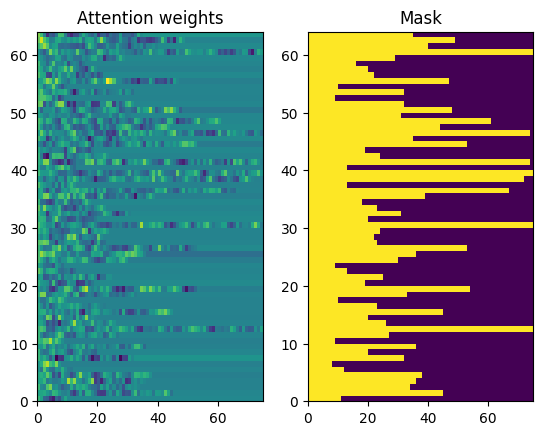

In [51]:
attention_weights = attention_layer.last_attention_weights
mask=(question_tok != 0).numpy()

plt.subplot(1, 2, 1)
plt.pcolormesh(attention_weights[:, 0, :])
plt.title('Attention weights')

plt.subplot(1, 2, 2)
plt.pcolormesh(mask)
plt.title('Mask');

由于小随机初始化，注意力权重最初都接近 1/（sequence_length）。 

### 解码器

解码器预测answer_in序列中每个位置的下一个token。


- 通过嵌入层查询输入序列每个token的词嵌入向量。
- 使用RNN来处理词向量序列。
- 把RNN 输出作为注意力层的“查询”输入。
- 输出预测目标序列每一个位置下一个token的概率分布。

In [52]:
class Decoder(tf.keras.layers.Layer):
    @classmethod
    def add_method(cls, fun):
        setattr(cls, fun.__name__, fun)
        return fun

    def __init__(self, text_processor, units=256):
        super(Decoder, self).__init__()
        self.text_processor = text_processor
        self.vocab_size = text_processor.vocabulary_size()
         
        self.word_to_id = tf.keras.layers.StringLookup(vocabulary=text_processor.get_vocabulary(),
                                                       mask_token='', oov_token='[UNK]')
        self.id_to_word = tf.keras.layers.StringLookup(vocabulary=text_processor.get_vocabulary(),
                                                       mask_token='', oov_token='[UNK]',
                                                       invert=True)
        self.start_token = self.word_to_id(np.array('[START]',dtype=np.str_))
        self.end_token = self.word_to_id(np.array('[END]',dtype=np.str_))
        self.units = units
        # embedding layer converts token IDs to vectors
        self.embedding = tf.keras.layers.Embedding(self.vocab_size,
                                               units, mask_zero=True)
    
        # RNN keeps track of what's been generated so far.
        self.rnn = tf.keras.layers.GRU(units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')
        # RNN output will be the query for the attention layer.
        self.attention = CrossAttention(units)
        # This fully connected layer produces the logits for each
        # output token.
        self.output_layer = tf.keras.layers.Dense(self.vocab_size)

- context : question经过编码器后的输出结果
- x : answer_in

In [53]:
@Decoder.add_method
def call(self,context, x, state=None, return_state=False):  
    # Lookup the embeddings
    x = self.embedding(x)
    # Process the target sequence.
    x, state = self.rnn(x, initial_state=state)
    # Use the RNN output as the query for the attention over the context.
    x = self.attention(x, context)
    self.last_attention_weights = self.attention.last_attention_weights
    # Generate logit predictions for the next token.
    logits = self.output_layer(x)
    if return_state:
        return logits, state
    else:
        return logits

In [33]:
decoder = Decoder(answer_vectorization_layer, units=256)

logits = decoder(ex_question, answer_in)

print(f'encoder output shape: (batch, s, units) {ex_question.shape}')
print(f'input answer_in tokens shape: (batch, t) {answer_in.shape}')
print(f'logits shape shape: (batch, target_vocabulary_size) {logits.shape}')

encoder output shape: (batch, s, units) (64, 75, 256)
input answer_in tokens shape: (batch, t) (64, 124)
logits shape shape: (batch, target_vocabulary_size) (64, 124, 59768)


#### 推理

用start_toekn:`[START]`作为开始：

In [54]:
@Decoder.add_method
def get_initial_state(self, context):
    batch_size = tf.shape(context)[0]
    start_tokens = tf.fill([batch_size, 1], self.start_token)
    done = tf.zeros([batch_size, 1], dtype=tf.bool)
    embedded = self.embedding(start_tokens)
    return start_tokens, done, self.rnn.get_initial_state(embedded)[0]

过滤填充字符：

In [55]:
@Decoder.add_method
def tokens_to_text(self, tokens):
    words = self.id_to_word(tokens)
    result = tf.strings.reduce_join(words, axis=-1, separator=' ')
    result = tf.strings.regex_replace(result, '\[START\]', '')
    result = tf.strings.regex_replace(result, '\[END\]', '')
    result = tf.strings.regex_replace(result, '\[UNK\]','')
    return result

通过采样得到下一个token：

In [56]:
@Decoder.add_method
def get_next_token(self, context, next_token, done, state, temperature = 0.0):
    logits, state = self(context, next_token, state = state, return_state=True) 
    if temperature == 0.0:
        next_token = tf.argmax(logits, axis=-1)
    else:
        logits = logits[:, -1, :]/temperature
        next_token = tf.random.categorical(logits, num_samples=1)
    # If a sequence produces an `end_token`, set it `done`
    done = done | (next_token == self.end_token)
    # Once a sequence is done it only produces 0-padding.
    next_token = tf.where(done, tf.constant(0, dtype=tf.int64), next_token)
    return next_token, done, state

同自回归的方式生成文本：

In [37]:
# Setup the loop variables.
next_token, done, state = decoder.get_initial_state(ex_question)

tokens = []

for i in range(1, 11):
    # Run one step.
    next_token, done, state = decoder.get_next_token(ex_question, next_token, done, state, temperature=1.0)
    # Add the token to the output.
    tokens.append(next_token)
# Stack all the tokens together.
tokens = tf.concat(tokens, axis=-1) # (batch, t)
# Convert the tokens back to a a string
result = decoder.tokens_to_text(tokens)
for _ in result.numpy()[:5]:
    print(_.decode())

STII 缝里 需不需要 中如 葛根芩 眼下 主因 抗老 连子心 制
主任 甲灭 力所不及 四分之三 四物汤 不齐 维酸钾 社会保障 木糖醇 食生
深加工 股管 试服 袭击 妊高症 性寒味 今古 血要 泡发 中下旬
先验 渠道 15mg 穹隆 骨密度 绿茶 些 唾腺 螃蟹 承受不住
维一素 还会压 宗合 盘腿 归纳 鞭毛虫 心神 上移 平性 240


### 构建模型

- 编码器 + 注意力 + 解码器 $\to$ 模型

In [57]:
class Translator(tf.keras.Model):
    @classmethod
    def add_method(cls, fun):
        setattr(cls, fun.__name__, fun)
        return fun

    def __init__(self, units, question_text_processor,
                 answer_text_processor):
        super().__init__()
        # Build the encoder and decoder
        encoder = Encoder(question_text_processor, units)
        decoder = Decoder(answer_text_processor, units)

        self.encoder = encoder
        self.decoder = decoder

    def call(self, inputs):
        question, answer_in = inputs
        question = self.encoder(question)
        logits = self.decoder(question, answer_in)
        #TODO(b/250038731): remove this
        try:
              # Delete the keras mask, so keras doesn't scale the loss+accuracy. 
            del logits._keras_mask
        except AttributeError:
            pass
        return logits

In [58]:
model = Translator(256, question_vectorization_layer, answer_vectorization_layer)

logits = model((question_tok, answer_in))

print(f'Question tokens, shape: (batch, s, units) {question_tok.shape}')
print(f'Answer_in tokens, shape: (batch, t) {answer_in.shape}')
print(f'logits, shape: (batch, t, target_vocabulary_size) {logits.shape}')

Question tokens, shape: (batch, s, units) (64, 75)
Answer_in tokens, shape: (batch, t) (64, 124)
logits, shape: (batch, t, target_vocabulary_size) (64, 124, 59768)


#### Loss和Metric

In [59]:
def masked_loss(y_true, y_pred):
    # Calculate the loss for each item in the batch.
    loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(
                        from_logits=True, reduction='none')
    loss = loss_fn(y_true, y_pred)
    # Mask off the losses on padding.
    mask = tf.cast(y_true != 0, loss.dtype)
    loss *= mask
    # Return the total.
    return tf.reduce_sum(loss)/tf.reduce_sum(mask)

In [60]:
def masked_acc(y_true, y_pred):
    # Calculate the loss for each item in the batch.
    y_pred = tf.argmax(y_pred, axis=-1)
    y_pred = tf.cast(y_pred, y_true.dtype)
    match = tf.cast(y_true == y_pred, tf.float32)
    mask = tf.cast(y_true != 0, tf.float32)
    return tf.reduce_sum(match)/tf.reduce_sum(mask)

In [61]:
model.compile(optimizer='adam',
              loss=masked_loss, 
              metrics=[masked_acc])

当前模型是随机初始化的，会给出大致一致的输出概率。因此，Loss和Accuracy的初始值是：

In [45]:
vocab_size = 1.0 * answer_vectorization_layer.vocabulary_size()

{"expected_loss": tf.math.log(vocab_size).numpy(),
 "expected_acc": 1/vocab_size}

{'expected_loss': 10.998226, 'expected_acc': 1.67313612635524e-05}

下面通过测试集验证如下：

In [46]:
model.evaluate(test_ds, steps=20, return_dict=True)

20/20 [==============================] - 10s 190ms/step - loss: 10.9970 - masked_acc: 1.2413e-05


{'loss': 10.996953964233398, 'masked_acc': 1.2413108379405458e-05}

In [47]:
model.summary()

Model: "translator_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_1 (Encoder)          multiple                  14869760  
_________________________________________________________________
decoder_1 (Decoder)          multiple                  33159800  
Total params: 48,029,560
Trainable params: 48,029,560
Non-trainable params: 0
_________________________________________________________________


#### 训练模型

In [62]:
history = model.fit(train_ds.repeat(), epochs=100,
                    steps_per_epoch = 1000,
                    validation_data = test_ds,
                    validation_steps = 20,
                    callbacks=[tf.keras.callbacks.EarlyStopping(patience=3)])

Epoch 1/100
1000/1000 [==============================] - 317s 305ms/step - loss: 5.5534 - masked_acc: 0.1849 - val_loss: 4.3384 - val_masked_acc: 0.2744
Epoch 2/100
1000/1000 [==============================] - 302s 302ms/step - loss: 3.9044 - masked_acc: 0.3086 - val_loss: 3.7822 - val_masked_acc: 0.3286
Epoch 3/100
1000/1000 [==============================] - 303s 303ms/step - loss: 3.5184 - masked_acc: 0.3494 - val_loss: 3.4996 - val_masked_acc: 0.3641
Epoch 4/100
1000/1000 [==============================] - 302s 302ms/step - loss: 3.1584 - masked_acc: 0.3866 - val_loss: 3.4521 - val_masked_acc: 0.3790
Epoch 5/100
1000/1000 [==============================] - 303s 303ms/step - loss: 3.0122 - masked_acc: 0.4073 - val_loss: 3.3358 - val_masked_acc: 0.3981
Epoch 6/100
1000/1000 [==============================] - 302s 302ms/step - loss: 2.8398 - masked_acc: 0.4290 - val_loss: 3.3117 - val_masked_acc: 0.4101
Epoch 7/100
1000/1000 [==============================] - 303s 303ms/step - loss: 2

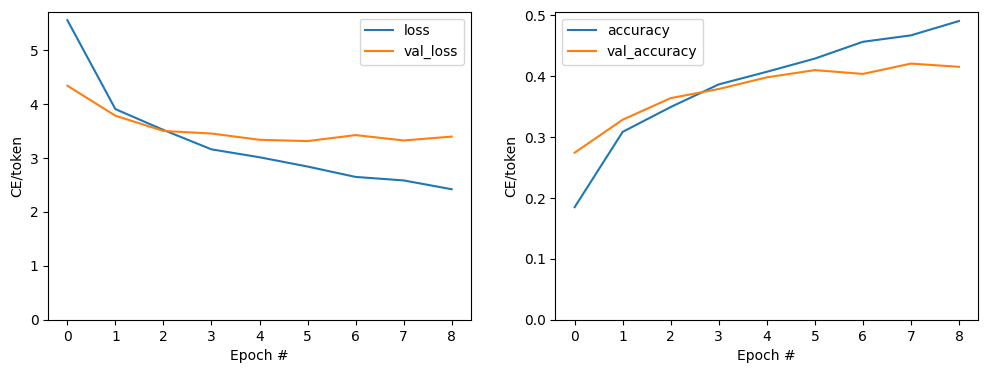

In [63]:
plt.figure(figsize=(12, 4))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch #')
plt.ylabel('CE/token')
plt.legend()
plt.subplot(1,2,2)
plt.plot(history.history['masked_acc'], label='accuracy')
plt.plot(history.history['val_masked_acc'], label='val_accuracy')
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch #')
plt.ylabel('CE/token')
plt.legend()

In [64]:
@Translator.add_method
def translate(self, texts, *, max_length=125, temperature=0.0):
    # Process the input texts
    context = self.encoder.convert_input(texts)
    batch_size = tf.shape(texts)[0]

    # Setup the loop inputs
    tokens = []
    attention_weights = []
    next_token, done, state = self.decoder.get_initial_state(context)

    for _ in range(max_length):
        # Generate the next token
        next_token, done, state = self.decoder.get_next_token(context, next_token, done,  state, temperature)
        # Collect the generated tokens
        tokens.append(next_token)
        attention_weights.append(self.decoder.last_attention_weights)

        if tf.executing_eagerly() and tf.reduce_all(done):
            break

    # Stack the lists of tokens and attention weights.
    tokens = tf.concat(tokens, axis=-1)   # t*[(batch 1)] -> (batch, t)
    self.last_attention_weights = tf.concat(attention_weights, axis=1)  # t*[(batch 1 s)] -> (batch, t s)

    result = self.decoder.tokens_to_text(tokens)
    return result

In [65]:
question_text = ' '.join(question_df.wordslist[0])
print(question_text)

头痛 恶心 肌肉 痛 关节痛 颈部 淋巴结 疼痛 怎么回事 啊


In [66]:
result = model.translate([question_text]) # Are you still home
result[0].numpy().decode()

'你 的 症状 可能 是 感冒 引起 的 症状 ， 建议 你 可以 服用 感康 进行 治疗 ， 注意 休息 ， 多喝水 ， 注意 休息 ， 避免 劳累 ， 注意 保暖 ， 避免 着凉 感冒 '

#### 可视化注意力矩阵

In [67]:
import matplotlib
matplotlib.rc("font", family='DejaVu Serif')

In [68]:
@Translator.add_method
def plot_attention(self, text, **kwargs):
    assert isinstance(text, str)
    output = self.translate([text], **kwargs)
    output = output[0].numpy().decode()

    attention = self.last_attention_weights[0]

    context = add_start_end_token(text)
    context = context.numpy().decode().split()

    output = add_start_end_token(output)
    output = output.numpy().decode().split()[1:]

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(1, 1, 1)

    ax.matshow(attention, cmap='viridis', vmin=0.0)

    fontdict = {'fontsize': 14}

    #ax.set_xticklabels([''] + context, fontdict=fontdict, rotation=90)
    #ax.set_yticklabels([''] + output, fontdict=fontdict)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    ax.set_xlabel('Input text')
    ax.set_ylabel('Output text')

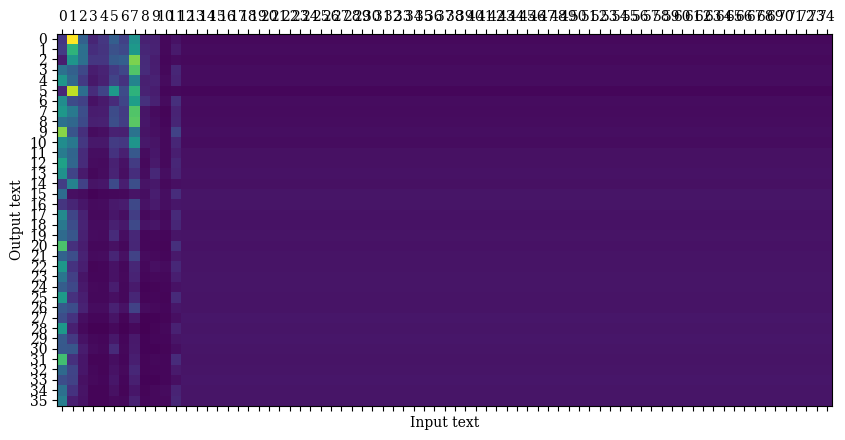

In [69]:
model.plot_attention(question_text)

In [70]:
question_text = ' '.join(question_df.wordslist[112])
print("question :",question_text)
result = model.translate([question_text]) # Are you still home
result = result[0].numpy().decode()
print("answer :",result)

question : 一月 前 左手 肌腱 断掉 一个月 前 左手 内侧 血管 肌腱 断 了 在 回复 期间 大拇指 的 筋 又 断 了
answer : 这个 情况 要 考虑 手术 的 ， 建议 你 可以 到 医院 骨科 就诊 ， 做 核磁共振 检查 


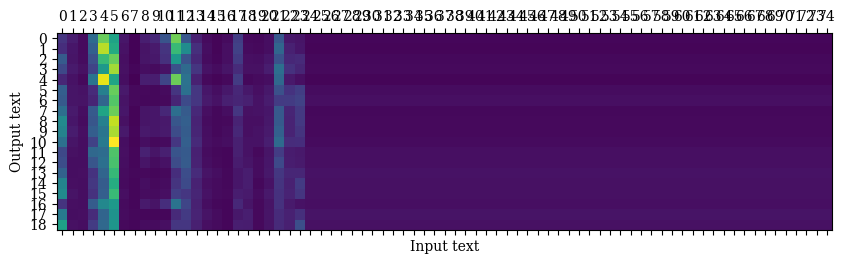

In [71]:
model.plot_attention(question_text)

短句子通常效果很好，但如果输入太长，模型实际上会失去焦点并停止提供合理的预测。这主要有两个原因：

1. 模型强制在每一步输入正确的令牌进行训练，而不管模型的预测如何。如果模型有时被输入自己的预测，它可以变得更加稳健。
2. 该模型只能通过 RNN 状态访问其先前的输出。如果 RNN 状态失去了对它在上下文序列中的位置的跟踪，则模型无法恢复。

#### 批处理

In [72]:
inputs = [question_text, question_text, question_text]

In [73]:
%%time
for t in inputs:
    print(model.translate([t])[0].numpy().decode())

这个 情况 要 考虑 手术 的 ， 建议 你 可以 到 医院 骨科 就诊 ， 做 核磁共振 检查 
这个 情况 要 考虑 手术 的 ， 建议 你 可以 到 医院 骨科 就诊 ， 做 核磁共振 检查 
这个 情况 要 考虑 手术 的 ， 建议 你 可以 到 医院 骨科 就诊 ， 做 核磁共振 检查 
CPU times: user 5.73 s, sys: 112 ms, total: 5.84 s
Wall time: 5.77 s


In [266]:
%%time
result = model.translate(inputs)

print(result[0].numpy().decode())
print(result[1].numpy().decode())
print(result[2].numpy().decode())

你 的 情况 可能 是 由于 神经 压迫 神经 所致 的 ， 建议 你 可以 到 医院 做 一下 相关检查 ， 明确 后 再 治疗 。 
你 的 情况 可能 是 由于 神经 压迫 神经 所致 的 ， 建议 你 可以 到 医院 做 一下 相关检查 ， 明确 后 再 治疗 。 
你 的 情况 可能 是 由于 神经 压迫 神经 所致 的 ， 建议 你 可以 到 医院 做 一下 相关检查 ， 明确 后 再 治疗 。 
CPU times: user 2.72 s, sys: 27.9 ms, total: 2.75 s
Wall time: 2.72 s


### 导出模型

只保存Translate方法：

In [267]:
class Export(tf.Module):
    def __init__(self, model):
        self.model = model

    @tf.function(input_signature=[tf.TensorSpec(dtype=tf.string, shape=[None])])
    def translate(self, inputs):
        return self.model.translate(inputs)

In [268]:
export = Export(model)

In [270]:
%%time
# run for compile
_ = export.translate(tf.constant(inputs))

CPU times: user 2min 18s, sys: 2.98 s, total: 2min 21s
Wall time: 2min 21s


In [271]:
%%time
result = export.translate(tf.constant(inputs))

print(result[0].numpy().decode())
print(result[1].numpy().decode())
print(result[2].numpy().decode())
print()

你 的 情况 可能 是 由于 神经 压迫 神经 所致 的 ， 建议 你 可以 到 医院 做 一下 相关检查 ， 明确 后 再 治疗 。                                                                                                   
你 的 情况 可能 是 由于 神经 压迫 神经 所致 的 ， 建议 你 可以 到 医院 做 一下 相关检查 ， 明确 后 再 治疗 。                                                                                                   
你 的 情况 可能 是 由于 神经 压迫 神经 所致 的 ， 建议 你 可以 到 医院 做 一下 相关检查 ， 明确 后 再 治疗 。                                                                                                   

CPU times: user 538 ms, sys: 70.7 ms, total: 609 ms
Wall time: 519 ms


#### 保存模型

In [272]:
%%time
tf.saved_model.save(export, 'translator',
                    signatures={'serving_default': export.translate})

INFO:tensorflow:Assets written to: translator/assets


INFO:tensorflow:Assets written to: translator/assets


CPU times: user 2min 38s, sys: 3.97 s, total: 2min 42s
Wall time: 2min 41s


#### 加载模型

In [273]:
%%time
reloaded = tf.saved_model.load('translator')
_ = reloaded.translate(tf.constant(inputs)) #warmup

CPU times: user 2min 7s, sys: 3.83 s, total: 2min 11s
Wall time: 2min 11s


In [275]:
%%time
result = reloaded.translate(inputs)

print(result[0].numpy().decode())
print(result[1].numpy().decode())
print(result[2].numpy().decode())
print()

你 的 情况 可能 是 由于 神经 压迫 神经 所致 的 ， 建议 你 可以 到 医院 做 一下 相关检查 ， 明确 后 再 治疗 。                                                                                                   
你 的 情况 可能 是 由于 神经 压迫 神经 所致 的 ， 建议 你 可以 到 医院 做 一下 相关检查 ， 明确 后 再 治疗 。                                                                                                   
你 的 情况 可能 是 由于 神经 压迫 神经 所致 的 ， 建议 你 可以 到 医院 做 一下 相关检查 ， 明确 后 再 治疗 。                                                                                                   

CPU times: user 541 ms, sys: 52 ms, total: 593 ms
Wall time: 507 ms


### 优化

更快的预测、保存和加载速度。

当前的translate方法并不是最佳实现，缺点如下：
1. 它制作循环体的副本。因此，生成的图形需要更长的时间来构建、保存和加载。
2. 必须选择一个固定的max_length。
3. tf.function 在每次调用上运行完整迭代，且只能在`eager execution`下工作，速度略慢。

为了修复这些缺点，下面的方法使用了一个张量流循环，它看起来像一个python循环，但是当你使用张量作为循环的输入（或循环的条件）时，tf.function使用tf.while_loop等操作将其转换为动态循环。`max_length`只是以防万一模型卡住生成一个循环，例如：`1, 2, 1, 2, 1 ...`同时通过tf.TensorArray保存生成的token。

In [74]:
import einops

In [75]:
@Translator.add_method
def translate(self, texts, *, max_length=125,
              temperature=tf.constant(0.0)):
   
    context = self.encoder.convert_input(texts)
    batch_size = tf.shape(context)[0]
    next_token, done, state = self.decoder.get_initial_state(context)

    # initialize the accumulator
    tokens = tf.TensorArray(tf.int64, size=1, dynamic_size=True)

    for t in tf.range(max_length):
        # Generate the next token
        next_token, done, state = self.decoder.get_next_token(
                                    context, next_token, done, state, temperature)
        # Collect the generated tokens
        tokens = tokens.write(t, next_token)

        # if all the sequences are done, break
        if tf.reduce_all(done):
            break

    # Convert the list of generated token ids to a list of strings.
    tokens = tokens.stack()
    tokens = einops.rearrange(tokens, 't batch 1 -> batch t')
    text = self.decoder.tokens_to_text(tokens)
    return text

In [76]:
%%time
result = model.translate(inputs)

print(result[0].numpy().decode())
print(result[1].numpy().decode())
print(result[2].numpy().decode())
print()

这个 情况 要 考虑 手术 的 ， 建议 你 可以 到 医院 骨科 就诊 ， 做 核磁共振 检查 
这个 情况 要 考虑 手术 的 ， 建议 你 可以 到 医院 骨科 就诊 ， 做 核磁共振 检查 
这个 情况 要 考虑 手术 的 ， 建议 你 可以 到 医院 骨科 就诊 ， 做 核磁共振 检查 

CPU times: user 1.93 s, sys: 38 ms, total: 1.97 s
Wall time: 1.94 s


In [83]:
class Export(tf.Module):
    def __init__(self, model):
        self.model = model

    @tf.function(input_signature=[tf.TensorSpec(dtype=tf.string, shape=[None])])
    def translate(self, inputs):
        return self.model.translate(inputs)

In [84]:
export = Export(model)

In [85]:
%%time
_ = export.translate(inputs)

CPU times: user 3.96 s, sys: 117 ms, total: 4.07 s
Wall time: 4.03 s


In [86]:
%%time
result = export.translate(inputs)

print(result[0].numpy().decode())
print(result[1].numpy().decode())
print(result[2].numpy().decode())
print()

这个 情况 要 考虑 手术 的 ， 建议 你 可以 到 医院 骨科 就诊 ， 做 核磁共振 检查 
这个 情况 要 考虑 手术 的 ， 建议 你 可以 到 医院 骨科 就诊 ， 做 核磁共振 检查 
这个 情况 要 考虑 手术 的 ， 建议 你 可以 到 医院 骨科 就诊 ， 做 核磁共振 检查 

CPU times: user 132 ms, sys: 10.2 ms, total: 142 ms
Wall time: 94.2 ms


#### 保存和加载

In [89]:
%%time
tf.saved_model.save(export, 'dynamic_translator',
                    signatures={'serving_default': export.translate})

INFO:tensorflow:Assets written to: dynamic_translator/assets


INFO:tensorflow:Assets written to: dynamic_translator/assets


CPU times: user 45 s, sys: 2.17 s, total: 47.1 s
Wall time: 50.2 s


In [90]:
%%time
reloaded = tf.saved_model.load('dynamic_translator')
_ = reloaded.translate(tf.constant(inputs)) #warmup

CPU times: user 19.6 s, sys: 486 ms, total: 20.1 s
Wall time: 20 s


In [91]:
%%time
result = reloaded.translate(tf.constant(inputs))

print(result[0].numpy().decode())
print(result[1].numpy().decode())
print(result[2].numpy().decode())
print()

这个 情况 要 考虑 手术 的 ， 建议 你 可以 到 医院 骨科 就诊 ， 做 核磁共振 检查 
这个 情况 要 考虑 手术 的 ， 建议 你 可以 到 医院 骨科 就诊 ， 做 核磁共振 检查 
这个 情况 要 考虑 手术 的 ， 建议 你 可以 到 医院 骨科 就诊 ， 做 核磁共振 检查 

CPU times: user 125 ms, sys: 21.7 ms, total: 147 ms
Wall time: 105 ms


In [87]:
def answer_postprocess(answer):
    words = answer.split(' ')
    return ''.join(words)

### Test

In [78]:
import time

In [79]:
def printer(text, delay=0.2):
    """打字机效果"""
    
    for i,ch in enumerate(text):
        if (i+1)%35 == 0:
            print('\n')
        else:
            print(ch, end='', flush=True)
            time.sleep(delay)

In [80]:
sample_ques = question_df.sample(5)

In [81]:
sample_ques

,question_id,content,wordslist,wordlist
102232,44821330,盆腔积液会引起腿麻么？最近两个月总是右腿麻走路都不敢使劲还右侧腰痛。因为例假不正常，所以看了...,"[盆腔, 积液, 会, 引起, 腿, 麻, 么, ？, 最近, 两个, 月, 总是, 右腿,...","[盆, 腔, 积, 液, 会, 引, 起, 腿, 麻, 么, ？, 最, 近, 两, 个, ..."
97676,34448561,排卵试纸检测线深什么意思中午1点排卵试纸检测线很深，对照线很模糊，请问现在同房还是晚上同房易...,"[排卵, 试纸, 检测线, 深, 什么, 意思, 中午, 1, 点, 排卵, 试纸, 检测线...","[排, 卵, 试, 纸, 检, 测, 线, 深, 什, 么, 意, 思, 中, 午, 1, ..."
11185,4314547,我男友患早泄，我们没有性生活。后来偶然遇见了现在的情人。情人的做爱招术有很多，我在满足的同时...,"[我, 男友, 患, 早泄, ，, 我们, 没有, 性生活, 。, 后来, 偶然, 遇见, ...","[我, 男, 友, 患, 早, 泄, ，, 我, 们, 没, 有, 性, 生, 活, 。, ..."
84085,15191663,晚上睡觉鼻子凉，早上起来又觉得热，请问是啥原因,"[晚上, 睡觉, 鼻子, 凉, ，, 早上, 起来, 又, 觉得, 热, ，, 请问, 是,...","[晚, 上, 睡, 觉, 鼻, 子, 凉, ，, 早, 上, 起, 来, 又, 觉, 得, ..."
93341,54703772,:我的月经是昨天干净的我明天能做性激素六项抽血检查吗？,"[:, 我, 的, 月经, 是, 昨天, 干净, 的, 我, 明天, 能, 做, 性激素, ...","[:, 我, 的, 月, 经, 是, 昨, 天, 干, 净, 的, 我, 明, 天, 能, ..."


In [92]:
for question, text in zip(sample_ques.content, sample_ques.wordslist):
    qtext = ' '.join(text)
    printer("问： "+question+'\n', 0.05)
    print('\n')
    answer = reloaded.translate([qtext])[0].numpy().decode()
    answer = answer_postprocess(answer)
    printer("答： "+answer+'\n',0.15)
    print('\n')

问： 盆腔积液会引起腿麻么？最近两个月总是右腿麻走路都不敢使劲还右侧

痛。因为例假不正常，所以看了妇科检盆腔积液会引起腿麻么？最近两个月总

右腿麻走路都不敢使劲还右侧腰痛。因为例假不正常，所以看了妇科检查是盆

积液子宫内膜厚。这些会引起腿麻么？还是别的问题？


答： 盆腔炎的治疗主要以抗炎为主，治疗主要是对症治疗，如盆腔炎、附件

、盆腔炎等，建议你到正规医院妇科检查，查明病因，对症治疗。


问： 排卵试纸检测线深什么意思中午1点排卵试纸检测线很深，对照线很模

，请问现在同房还是晚上同房易怀孕，谢谢


答： 排卵日期一般在下次月经来潮前的14天左右，下次月经来潮的第1天

起，倒数14天或减去14天就是排卵日，排卵日及其前5天和后4天加在一

称为排卵期。你的情况建议你最好是在排卵期同房，怀孕的可能性比较大。


问： 我男友患早泄，我们没有性生活。后来偶然遇见了现在的情人。情人的

爱招术有很多，我在满足的同时也很困惑…他常用他大大的那个在我乳沟里抽

…还要我给他口*交，最后射精在我嘴里…调情的时候我出了好多水，他总是

我舔…我们这样的性生活是不是有问题啊？对身体有伤害吗？


答： 这个情况是不会的，不要担心，这个是不会的，不要担心


问： 晚上睡觉鼻子凉，早上起来又觉得热，请问是啥原因


答： 你的这种情况可能是由于受凉引起的鼻腔粘膜充血，或者是由于受凉引

的，建议你可以服用一些风寒感冒冲剂，可以服用感康，元胡止痛片等进行治

，注意休息，注意保暖，避免着凉，注意保暖，避免着凉，注意保暖，避免着




问： :我的月经是昨天干净的我明天能做性激素六项抽血检查吗？


答： 月经推迟一周是正常的，月经推迟一周是正常现象，一般月经推迟一周

正常现象。你可以到药店买到医院看看，让医生看看，吃一点消炎药。




In [342]:
q = "头疼闹热，浑身难受，四肢无力"

In [343]:
text = ' '.join(jieba.cut(q))
text

'头疼 闹热 ， 浑身 难受 ， 四肢无力'

In [345]:
answer = reloaded.translate([text])[0].numpy().decode()

In [346]:
answer_postprocess(answer)

'你的情况考虑是由于感冒引起的，建议你可以服用感康，VC银翘片，阿莫西林，尼美舒利治疗，多喝温开水，忌辛辣油腻食物，多吃蔬菜水果，多喝水，避免着凉。'